# 一、参数更新

神经网络的目的是找到使损失函数最小的参数，即寻找最优参数（最优解）的问题。但在许多神经网络中，寻找最优参数是非常困难的，原因有两个：参数空间非常庞大、参数量很大。

在之前的神经网络中，我们都使用的是SGD（随机梯度下降法）作为线索来寻找最优解，这是最简单的方法，但它也存在一定的局限性，接下来就来看看SGD的局限性和一些比它更优的方法。



## 1.1SGD

现在再来回顾一下之前讲的SGD原理，SGD用公式表示如下：

![image-20230401200243740](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230401200243740.png)

接下来将SGD封装成一个类，用于更新模型的参数：

In [6]:
class SGD:
    def __init__(self, lr) -> None:
        self.lr = lr

    def update(self, params, grads):  # python中list和dict做形参原数据都会被改变
        for key in params.keys():
            params[key] -= self.lr * grads[key]


如果在训练代码中想要更新参数，就可以：

```py
optimizer = SGD()
```

然后调用SGD中的`update()`方法，就能轻松更新参数。同样的，如果把SGD替换成别的参数更新方法，比如Momentum，直接在创建对象的时候写成：

```py
optimizer = Momentum()
```

使用和修改起来非常方便，这就是模块化的好处。像这样，每个模块中都的各种方法都封装好了，就是一个深度学习框架（比如：损失函数模块里封装了各种求损失函数的方法，激活函数模块中封装了各种求激活函数的方法...最后使用的时候直接像拼积木一样，想用哪个方法就到对应的模块中找，然后拼起来就完成一个神经网络的搭建和计算，大大节省时间）

## 1.2SGD的缺点

SGD简单归简单，但是在实现某些问题的时候会显得没有效率。

用一个例子来说明，求下面这个函数的最小值：

![image-20230401210028823](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230401210028823.png)

先来看一看这个函数的图像是什么样子的：

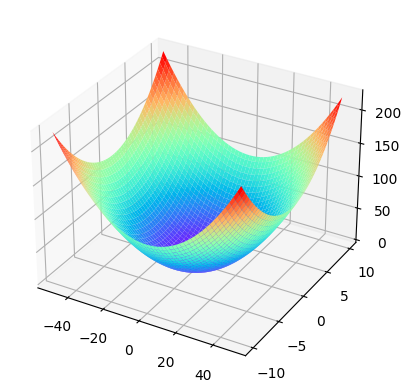

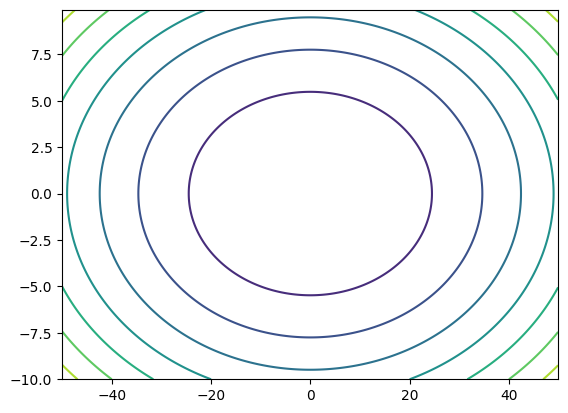

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#设置图像为三维格式
figure = plt.figure()
ax = plt.axes(projection='3d')

#确定输入范围
X = np.arange(-50, 50, 0.1)
Y = np.arange(-10, 10, 0.1)

#绘制网格
X, Y = np.meshgrid(X, Y)

#确定表达式
Z = 1 / 20 * X ** 2 + Y ** 2

#画图
ax.plot_surface(X, Y, Z, cmap='rainbow')
plt.show()
plt.contour(X, Y, Z)
plt.show()

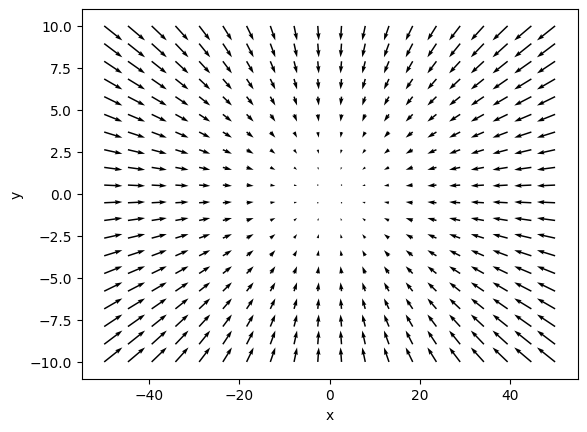

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# define the function
def func(x, y):
    return 1 / 20 * x ** 2 + y ** 2


# define gradient function
def gradient(x, y):
    return np.gradient(func(x, y))


# generate the input
x = np.linspace(-50, 50, 20)
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)

# calculate the gradient
Gy, Gx = gradient(X, Y)

# plot the gradient graph
plt.quiver(X, Y, -Gx, -Gy)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

解释一下上述代码中的`np.gradient`函数，这个函数的作用是求给定的数组的各个位置上的梯度，返回值是每个每个参数在各个位置上梯度的分量大小。

比如，先看一维数组，一维数组对应的就是一元函数，现有一维数组`a=[10,  0,  7,  0, 19]`，要求每个位置上的梯度，使用中心差分，即对`a[k]`求梯度，就是求`(a[k+1]-a[k-1])/(2*1)`。特殊的，两个端点，直接用后面减去前面即可。例如：`d(a[0])=0-10=-10`，`d(a[1])=(7-10)/2=-1.5`，...，所以最后输出为`da=[-10. ,  -1.5,   0. ,   6. ,  19. ]`

再看二维数组，二维数组对应二元函数，两个维度分别对应$xy$两个自变量的取值，对二维数组求梯度，与一维数组方法基本一致，假设$y$是纵轴，$x$是横轴，对$x$求梯度，就是对每一行按照一维数组的求法求解；对$y$求梯度，就是对每一列从上往下按照一维数组的方法求。例如：

```py
a = np.array([[25, 49, 14, 13, 20],
              [43,  6, 13, 15, 24],
              [ 9,  2,  7,  5, 36]])
Dy,Dx = np.gradient(a)
```

有几个自变量就返回几个同型数组，对于二维数组，`np.gradient`函数第一维返回的是纵向求梯度的结果，即返回对$y$的梯度，第二维返回的是对$x$求梯度的结果，即

```py
[array([[ 18. , -43. ,  -1. ,   2. ,   4. ],
        [ -8. , -23.5,  -3.5,  -4. ,   8. ],
        [-34. ,  -4. ,  -6. , -10. ,  12. ]]),
 array([[ 24. ,  -5.5, -18. ,   3. ,   7. ],
        [-37. , -15. ,   4.5,   5.5,   9. ],
        [ -7. ,  -1. ,   1.5,  14.5,  31. ]])]
```

之后看一下上述代码中的`quiver`函数，该函数用来画箭头，第1、2参数是就是每个箭头的起点（$xy$取值），第3、4参数是箭头的方向（梯度），又因为梯度是变化最快的方向，按照上述的中心差分求法，求出来的都是指向变大的方向，若要指向变小的方向，取个反就行了。

比如：

```py
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(-10,10,10)
y=-x**2

grad=np.gradient(y)

plt.plot(x,y)
plt.quiver(x,y,grad,np.zeros(x.size))
plt.show()
```

![Figure_1](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/Figure_1.png)

```py
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(-10,10,10)
y=x**2

grad=np.gradient(y)

plt.plot(x,y)
plt.quiver(x,y,grad,np.zeros(x.size))
plt.show()
```
![Figure_1](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/Figure_0.png)

言归正传，对该函数使用SGD，得到的搜索路径如下：

![image-20230403134126790](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403134126790.png)

可以发现，对于碗状函数，按照这种搜索路径效率实在太低，根本原因是，将梯度作为搜索的线索，找的是某一点下降最快的方向，并没有指向最小值的方向（可以理解为局部最优解不一定能构成全局最优解）。

## 1.3Momentum

Momentum是**动量**的意思，用数学式表示Momentum方法更新参数的过程：

![image-20230403134814847](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403134814847.png)

在分析这个方法之前，再来看一下这张图：

![image-20230403134126790](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403134126790.png)

为什么会导致参数的运动路线是像图中这样呈折线形的？

原因就是把运动方向（梯度）分解成$xy$两个方向上的分量，在每个点处，x方向分量都是统一朝右的；但在y方向的分量，是正负交替的。这就使得梯度在y方向上的波动非常大，但整体是朝右前进的。为了减小梯度的波动，可以采用多种平滑算法，如：移动平均法、加权移动平均法、指数加权移动平均法。下面对这三种方法进行详细介绍：

**（1）移动平均匀法**

收集一组观察值，计算这组观察值的均值，利用这个均值作为下一期的预测值。在移动平均值的计算中包括的过去观察值的实际个数，必须一开始就明确规定。用公式表示如下：

$$
F_{t+1}=\frac{(x_t+x_{t-1}+...+x_{t-N+1})}{N}
$$

其中，$x_k$表示第$k$次的实际值，$F_k$表示第$k$次预测值。

![](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403205614598.png)

**（2）加权移动平滑法**

加权移动平均给固定跨越期限内的每个变量值以相等的权重。公式如下：

$$
F_t=w_1A_{t-1}+w_2A_{t-2}+...w_nA_{t-n}
$$

**（3）指数加权移动平均法**

计算公式如下：

$$
V_{t+1}=\beta x_t+(1-\beta)\theta_{t+1}
$$

由实际值计算得到预测值，最后再用预测值替换掉对应的实际值，所得的数据就能够实现平滑效果。

**对指数加权平均法的进一步理解：**

假设$\beta=0.9$

![image-20230403213445769](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403213445769.png)

将各式代入第一个式子，可以得到![image-20230403213535493](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403213535493.png)

即：**第$k$次的结果包含了前面所有的数据的信息，并且越近的数据占比越大**。

接下来回到Momentum算法上来，观察算法的计算过程，可以发现

![image-20230403134814847](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403134814847.png)

和指数加权平均法的式子几乎完全一致，这里把$\frac{\partial L}{\partial W}$换成$dW$可得，$V_k=\alpha V_{k-1}-\eta dW_k=-\eta dW_k-\eta \alpha dW_{k-1}-...-\eta \alpha^{k-1}dW_1$。观察这个式子可以发现，如果$\alpha =0$，那么就退化成SGD了，同时，也可以看到，更新值$V_k$由两个部分组成，最近一次的梯度$-\eta dW_k$和后面一串尾巴$-\eta \alpha dW_{k-1}-...-\eta \alpha^{k-1}dW_1$，**$\alpha$的取值，决定了过去的若干梯度（尾巴）重要程度**。

在参数更新之前，先对梯度$dW$进行一次平滑处理，使能更快的到达最低点。

![image-20230403224339168](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230403224339168.png)

In [9]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9) -> None:
        self.lr = lr
        self.momentum = momentum
        self.V = None  # 保存上一次的预测值

    def update(self, params, grads):
        if self.V == None:
            self.V = {}
            for key, value in params.items():
                self.V[key] = np.zeros_like(value)

        for key in params.keys():
            self.V[key] = self.momentum * self.V[key] - self.lr * grads[key]
            params[key] += self.V[key]


下面测试一下直接用梯度和平滑后的梯度在参数更新路径上有什么不同：

**（1）SGD**

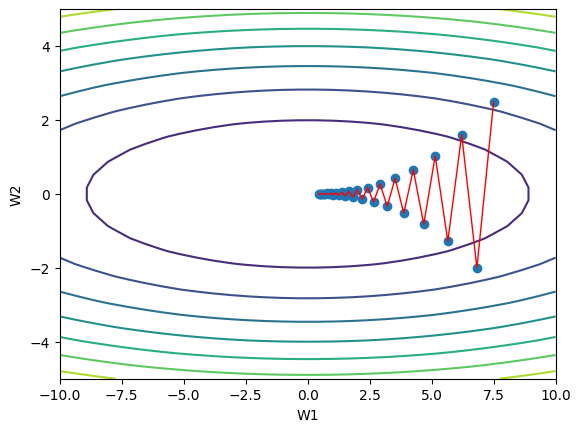

In [10]:
import sys,os

current_file_path = os.path.dirname(os.path.realpath('__file__'))
Demo_path = os.path.join(current_file_path, 'Demo')
sys.path.append(Demo_path)

import numpy as np
import matplotlib.pyplot as plt
from common.gradient import numerical_gradient_2d

def func(W):
    return 1 / 20 * W[0] ** 2 + W[1] ** 2

iter_num=30

optimizer=SGD(0.9)
W=np.array([7.5, 2.5])
grads={}
params={}
params['W']=W
history_w1_=[]
history_w2_=[]
history_w1_.append(W[0])
history_w2_.append(W[1])

for i in range(iter_num):
    #计算梯度
    grads['W']=numerical_gradient_2d(func,W)
    #更新参数
    optimizer.update(params,grads)
    #保存参数
    history_w1_.append(W[0])
    history_w2_.append(W[1])

w1 = np.linspace(-10, 10, 30)
w2 = np.linspace(-5, 5, 30)
W1, W2 = np.meshgrid(w1, w2)
Loss = 1 / 20 * W1 ** 2 + W2 ** 2
plt.contour(W1, W2, Loss)
plt.xlabel('W1')
plt.ylabel('W2')
plt.plot(history_w1_,history_w2_,'o')
plt.plot(history_w1_,history_w2_,linewidth=1,color='red')

plt.show()

**（2）Momentum**

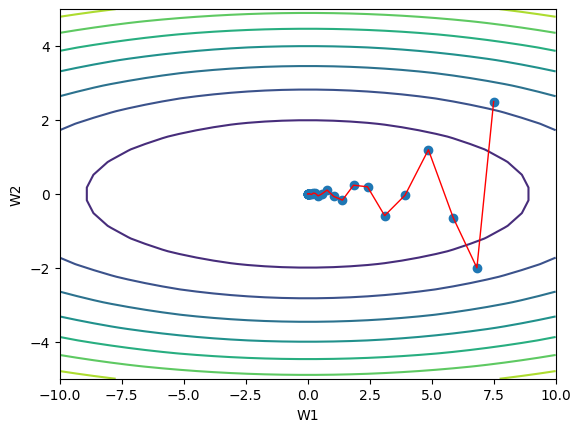

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from common.gradient import numerical_gradient_2d

def func(W):
    return 1 / 20 * W[0] ** 2 + W[1] ** 2

iter_num=30

optimizer=Momentum(0.9,0.5)
W=np.array([7.5, 2.5])
grads={}
params['W']=W
history_w1=[]
history_w2=[]
history_w1.append(W[0])
history_w2.append(W[1])

for i in range(iter_num):
    #计算梯度
    grads['W']=numerical_gradient_2d(func,W)
    #更新参数
    optimizer.update(params,grads)
    #保存参数
    history_w1.append(W[0])
    history_w2.append(W[1])

w1 = np.linspace(-10, 10, 30)
w2 = np.linspace(-5, 5, 30)
W1, W2 = np.meshgrid(w1, w2)
Loss = 1 / 20 * W1 ** 2 + W2 ** 2
plt.contour(W1, W2, Loss)
plt.xlabel('W1')
plt.ylabel('W2')
plt.plot(history_w1,history_w2,'o')
plt.plot(history_w1,history_w2,linewidth=1,color='red')

plt.show()

把SGD和Momentum放到一起做个对比：

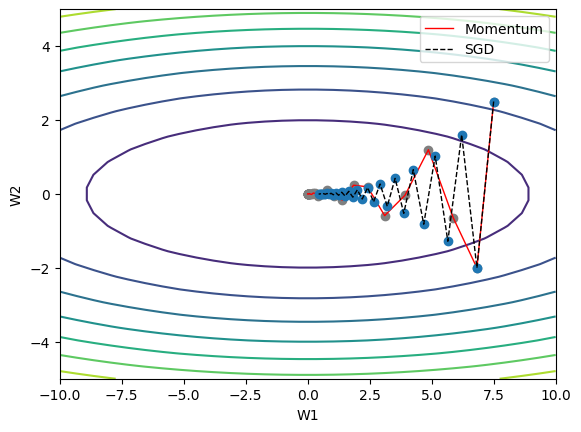

In [12]:
w1 = np.linspace(-10, 10, 30)
w2 = np.linspace(-5, 5, 30)
W1, W2 = np.meshgrid(w1, w2)
Loss = 1 / 20 * W1 ** 2 + W2 ** 2
plt.contour(W1, W2, Loss)
plt.xlabel('W1')
plt.ylabel('W2')
plt.plot(history_w1, history_w2, 'o', color='grey')
plt.plot(history_w1, history_w2, linewidth=1, color='red', label='Momentum')
plt.plot(history_w1_, history_w2_, 'o')
plt.plot(history_w1_, history_w2_, linewidth=1, color='black', linestyle='--', label='SGD')
plt.legend()
plt.show()

上述图像将SGD和Momentum做对比，同样的学习率（learning_rate）和迭代次数（iter_num），使用Momentum收敛到最低点（中心(0,0)）的速度更快（因为20轮结束SGD明显还没到中心点），同时Momentum的曲线锯齿数减少，明显更加平滑

## 1.4AdaGrad

在神经网络的学习中，学习率（数学式中记为$\eta$）的值很重要。学习率过小，会导致学习花费过多时间；反过来，学习率过大，则会导致学习发散而不能正确进行。

在关于学习率的有效技巧中，有一种被称为 **学习率衰减（learning rate decay）** 的方法，即：**随着学习的进行，使学习率逐渐减小**（一开始多学，后来少学）。

逐渐减小学习率的想法，相当于将“全体”参数的学习率值一起降低。而AdaGrad进一步发展了这个想法，**针对“一个一个”的参数，赋予其“定制”的值**。

AdaGrad会为参数的每个元素适当地调整学习率，即：Adaptive Grad。下面为AdaGrad的算法：

![image-20230405200949969](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230405200949969.png)

其中，$\odot$ 表示对应矩阵元素的乘法。

观察上述算法的公式，可以得到以下结论：

**（1）何为“定制”？** 在式二中，某个参数的学习率是$\eta \frac{1}{\sqrt{h}}$，其中$\eta$是全局学习率即一个常数，$h$是由该参数的$\frac{\partial L}{\partial W}$得到的，所以参数的学习率是和该参数的梯度相关的。

**（2）何为“一开始多学，后来少学”？** 因为在学习的开始，距离参数的最优解还是很远的，学习率设置的大一点，有利于加快模型的收敛；但随着学习的进行，与最优解的距离越来越近，此时应该逐步减小学习率，防止某一时刻错过最优解导致模型发散。在上述公式中，可以看到$h$随着学习进行，是越来越大的（单调递增），这就导致参数学习率$\eta \frac{1}{\sqrt{h}}$越来越小。

下面用代码实现AdaGrad算法：

In [13]:
import numpy as np


class AdaGrad:
    def __init__(self, lr):
        self.h = {}
        self.lr = lr

    def update(self, params, grads):
        #h的初始值设为0
        if len(self.h) == 0:
            for key in params.keys():
                self.h[key] = np.zeros_like(params[key])
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  #+1e-7防止发生除0错误

下面用AdaGrad来看一下效果：

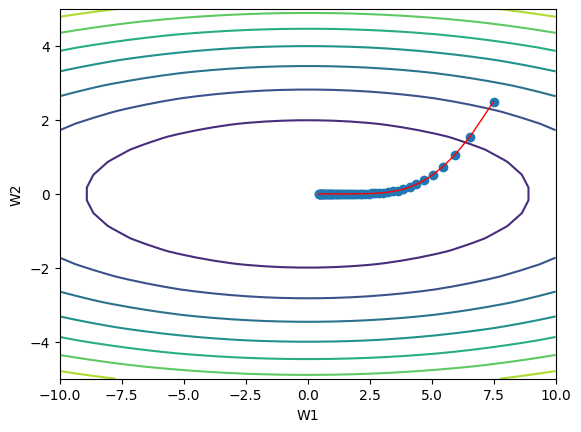

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from common.gradient import numerical_gradient_2d

def func(W):
    return 1 / 20 * W[0] ** 2 + W[1] ** 2

learning_rate=0.95
iter_num=50

W=np.array([7.5, 2.5])
params={}
params['W']=W
grads={}
history_w1=[]
history_w2=[]
history_w1.append(W[0])
history_w2.append(W[1])

optimizer = AdaGrad(learning_rate)

for i in range(iter_num):
    #计算梯度
    grads['W']=numerical_gradient_2d(func,W)
    #更新参数
    optimizer.update(params,grads)
    #保存参数
    history_w1.append(W[0])
    history_w2.append(W[1])

w1 = np.linspace(-10, 10, 30)
w2 = np.linspace(-5, 5, 30)
W1, W2 = np.meshgrid(w1, w2)
Loss = 1 / 20 * W1 ** 2 + W2 ** 2
plt.contour(W1, W2, Loss)
plt.xlabel('W1')
plt.ylabel('W2')
plt.plot(history_w1,history_w2,'o')
plt.plot(history_w1,history_w2,linewidth=1,color='red')
plt.show()

从上图中看出，一开始学习率是很大的，越往后越小。

## 1.5Adam

Momentum用于平滑梯度，加快收敛过程；AdaGrad用于调整学习率，防止模型发散。如果将这两者的优势结合起来，就得到了一种新的算法：Adam。

![image-20230406165804158](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230406165804158.png)

用代码实现如下：

In [15]:
class Adam:
    def __init__(self, beta1, beta2, lr) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr = lr
        self.m = None
        self.v = None
        self.t = 0

    def update(self, params, grads):
        if self.m == None:
            self.m = {}
            self.v = {}
            for key in params.keys():
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])

        self.t += 1

        for key in params.keys():
            self.m[key] = self.beta1*self.m[key]+(1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key]+(1-self.beta2)*(grads[key]**2)
            m_ = self.m[key]/(1-self.beta1**self.t)
            v_ = self.v[key]/(1-self.beta2**self.t)
            params[key] -= self.lr/(np.sqrt(v_)+1e-7)*m_


测试一下效果：

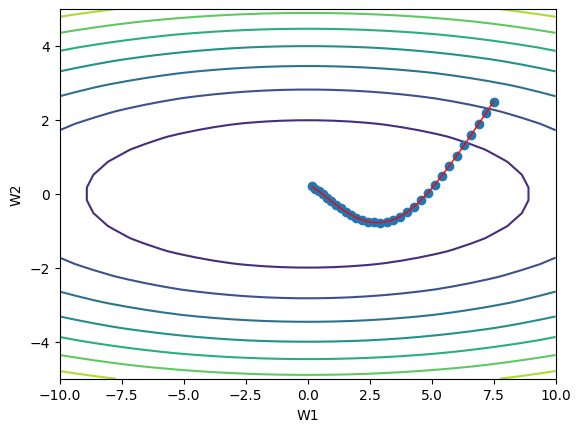

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from common.gradient import numerical_gradient_2d

def func(W):
    return 1 / 20 * W[0] ** 2 + W[1] ** 2

iter_num=30

W=np.array([7.5, 2.5])
params={}
params['W']=W
grads={}
history_w1=[]
history_w2=[]
history_w1.append(W[0])
history_w2.append(W[1])

optimizer = Adam(0.9,0.999,0.3)

for i in range(iter_num):
    #计算梯度
    grads['W']=numerical_gradient_2d(func,W)
    #更新参数
    optimizer.update(params,grads)
    #保存参数
    history_w1.append(W[0])
    history_w2.append(W[1])

w1 = np.linspace(-10, 10, 30)
w2 = np.linspace(-5, 5, 30)
W1, W2 = np.meshgrid(w1, w2)
Loss = 1 / 20 * W1 ** 2 + W2 ** 2
plt.contour(W1, W2, Loss)
plt.xlabel('W1')
plt.ylabel('W2')
plt.plot(history_w1,history_w2,'o')
plt.plot(history_w1,history_w2,linewidth=1,color='red')
plt.show()

【注】：Adam会设置 3个超参数。一个是学习率（论文中以α出现），另外两个是一次momentum系数β1和二次momentum系数β2。根据论文，标准的设定值是β1为 0.9，β2 为 0.999。设置了这些值后，大多数情况下都能顺利运行。

## 1.6如何选择合适的方法

每种方法对于不同问题都会表现出不同的性能，同时，超参数设置的不同，最后的结果也会有差异。

将上述的四种方法，汇总到一起看一下结果：

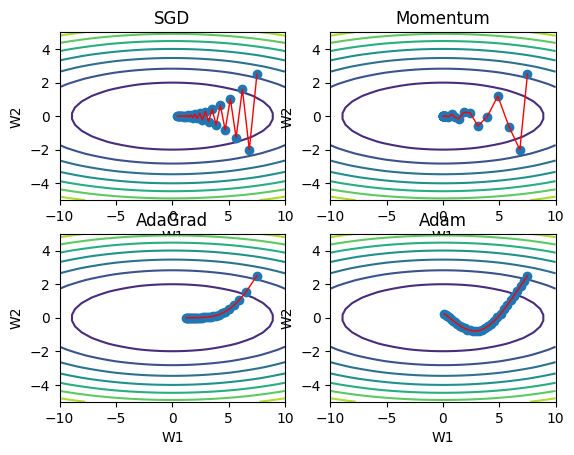

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from common.gradient import numerical_gradient_2d

def func(W):
    return 1 / 20 * W[0] ** 2 + W[1] ** 2

iter_num=30
idx=0

optimizers={}
optimizers['SGD']=SGD(0.9) #lr=0.9
optimizers['Momentum']=Momentum(0.9,0.5) #lr=0.9,momentum=0.5
optimizers['AdaGrad']=AdaGrad(0.95)
optimizers['Adam']=Adam(0.9,0.99,0.3)

for key in optimizers.keys():

    optimizer=optimizers[key]
    W=np.array([7.5, 2.5])
    grads={}
    params['W']=W
    history_w1=[]
    history_w2=[]
    history_w1.append(W[0])
    history_w2.append(W[1])

    for i in range(iter_num):
        #计算梯度
        grads['W']=numerical_gradient_2d(func,W)
        #更新参数
        optimizer.update(params,grads)
        #保存参数
        history_w1.append(W[0])
        history_w2.append(W[1])
    
    idx+=1
    plt.subplot(2,2,idx)
    w1 = np.linspace(-10, 10, 30)
    w2 = np.linspace(-5, 5, 30)
    W1, W2 = np.meshgrid(w1, w2)
    Loss = 1 / 20 * W1 ** 2 + W2 ** 2
    plt.contour(W1, W2, Loss)
    plt.title(key)
    plt.xlabel('W1')
    plt.ylabel('W2')
    plt.plot(history_w1,history_w2,'o')
    plt.plot(history_w1,history_w2,linewidth=1,color='red')

plt.show()

## 1.7基于Mnist数据集的方法比较

将上述的四种方法用在Minst数据集上进行比较，比较各方法的损失函数收敛的情况。

网络为每层100个神经元的5层网络。

===========iteration:0===========
SGD:2.3016008829525814
Momentum:2.390435665974005
AdaGrad:2.110477536340323
Adam:2.193828754836243
===========iteration:100===========
SGD:1.5701638825571802
Momentum:0.4280793883782116
AdaGrad:0.15134128301037011
Adam:0.3154445804598315
===========iteration:200===========
SGD:0.6830179902294958
Momentum:0.22126739292601383
AdaGrad:0.09918845550682964
Adam:0.17572220357074914
===========iteration:300===========
SGD:0.5894456545410329
Momentum:0.19480948818683422
AdaGrad:0.0713874640655639
Adam:0.1547824449415362
===========iteration:400===========
SGD:0.4856092493597043
Momentum:0.1866800656709636
AdaGrad:0.08291629540294662
Adam:0.11157964655601153
===========iteration:500===========
SGD:0.32713515116254627
Momentum:0.11343386091781137
AdaGrad:0.040122851859313635
Adam:0.060638149466991635
===========iteration:600===========
SGD:0.34338550405923113
Momentum:0.13753057819916453
AdaGrad:0.06251581278456272
Adam:0.10502592551872385
===========iteration:7

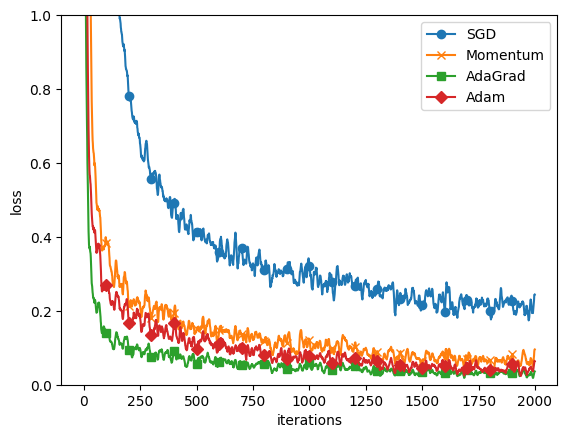

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


上图中可以发现，三种优化算法都比SGD收敛的速度更快。

# 二、权重的初始值

在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，经常关系到神经网络的学习能否成功。



## 2.1权重初始值不可为0

不能将权重初始值设为0。

【解释】：



## 2.2中间层的激活值分布

中间层的激活值：激活函数的输出数据。

权重的初始值设置会直接影响到中间层的激活函数输出值。这个输出值有什么用呢？做完下面这个实验，根据实验结果进行分析。

【实验】：对一个五层神经网络的五个中间层的激活函数输出值建立直方图。

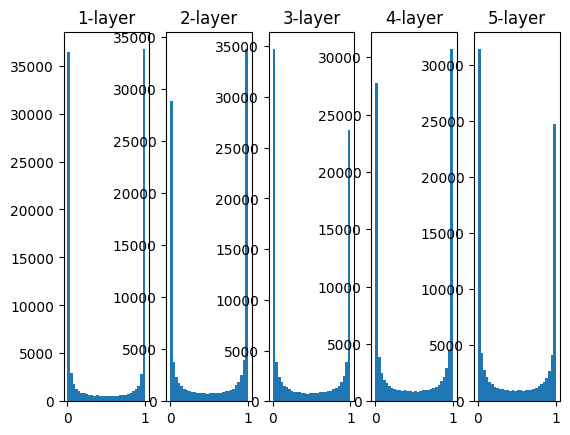

In [19]:
'''
    网络结构：100 100 100 100 100
    激活函数：sigmoid
    输入数据：标准正态分布生成1000条数据
    activations：保存各层激活值
'''

import numpy as np
import matplotlib.pyplot as plt


def sigmoid(X):
    return 1/(1+np.exp(-X))


# 输入数据(1000条size为100的数据)
X = np.random.randn(1000, 100)
# 各层神经元数量
node_num = 100
# 中间层层数
hidden_layer_num = 5
# 保存激活值
activations = {}

for i in range(hidden_layer_num):
    # 生成权重
    W = np.random.randn(node_num, node_num)*1 #标准差为1的正态分布
    # 计算Affine，并更新X
    X = sigmoid(np.dot(X, W))
    # 保存结果
    activations[i] = X

# 绘制直方图
for i, v in activations.items():
    plt.subplot(1, hidden_layer_num, i+1)
    plt.title(str(i+1)+'-layer')
    plt.hist(v.flatten(), 30, range=(0, 1))

plt.show()


从上图可以看出，每一层的输出值分布在0和1附近的占比是很高的，根据sigmoid函数图像：

![image-20230408173037905](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230408173037905.png)


得知：输出值偏向于0和1，那么输入值就是越往两端靠，对应的导数值就越偏向于0。按上面的例子来说，一共1000*10=10000个sigmoid输出值，在0和1附近的就有70000多个，从而反向传播求sigmoid梯度的时候，对应的就有70000多个梯度极小，非常接近于0（详细的可以看Sigmoid层反向传播的计算图，梯度=$y^2e^{-x}$）。等于说每经过一个sigmoid层，**反向传播**时70000条数据就要乘一次极小的梯度，随着网络层数的加深，数据乘极小梯度的次数会越来越多，导致**越靠近输入层，其乘上极小的梯度数量就越多**，最终就会趋向于0，从而导致这些个极小梯度处神经网络几乎不更新。这就是**梯度消失**，概括起来就是：<b><u>当神经网络层数增多时，越靠近输入层的层之间的权重无法得到有效修正（导数趋于0），从而得到神经网络效果不好</u></b>。

【实验】：如果将标准差设为0.01，进行与上述相同的实验，再次查看结果。

只需做如下修改：

```py
W = np.random.randn(node_num, node_num)*0.01 #标准差为0.01的正态分布
```

![image-20230408194602220](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230408194602220.png)

上图的结果与之前相比，输出的数据集中分布在0.5左右，因此不会发生梯度消失。

但是不是意味着这样的数据就是好的呢？

答案是否定的。数据值有所偏向（即：输出值都分布在某一个或几个值附近，其他地方很少或几乎没有），即多个神经元输出的内容差不多，那么其存在就没有意义了，多个神经元只用一个就可以了。这种现象被称为**表现力受限**。

>各层的激活值的分布都要求有适当的广度。为什么呢？因为通过在各层间传递多样性的数据，神经网络可以进行高效的学习。反过来，如果传递的是有所偏向的数据，就会出现梯度消失或者“表现力受限”的问题，导致学习可能无法顺利进行。

根据上面的两个实验可以发现：各层激活值的广度是很重要的。那应该如何控制激活值的广度？

这里运用一个现成的结论：**<u>如果前一层的节点数为n，则初始值使用标准差为$\frac{1}{\sqrt{n}}$的分布。</u>**

![image-20230408193318075](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230408193318075.png)

现在看看使用了该方法后的效果，代码中只需要修改为：

```py
W = np.random.randn(node_num, node_num) / np.sqrt(node_num)
```

![image-20230408194707930](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230408194707930.png)

## 2.3ReLU的权重初始值

当激活函数使用ReLU时，一般推荐使用ReLU专用的初始值。当前一层的节点数为$n$时，He初始值使用标准差为$\sqrt{\frac{2}{n}}$的正态分布。Xavier初始值是$\sqrt{\frac{1}{n}}$，这两个初始值可以简单的理解为：数据经过ReLU激活函数在负轴端的输出始终是0，所以这就会导致很大一批数据的输出是相同的。为了增加输出的广度，又因为输入具有随机性不可控，只能从权重的初始值入手，正态分布的标准差决定了概率密度函数的陡峭程度，即权重取值的广度，所以He初始值要比Xavier多一倍。（非专业性的解释，看看就行，理解的不对欢迎指正）

下图是ReLU激活函数在三种初始值下的激活值分布：

![image-20230409102710616](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230409102710616.png)

（1）标准差为0.01的正态分布：神经网络上传递的是非常小的值，说明逆向传播时权重的梯度也同样很小。这是很严重的问题，实际上学习基本上没有进展。

（2）Xavier：随着层的加深，偏向一点点变大。实际上，层加深后，越来越往0偏，激活值的偏向变大，学习时会出现梯度消失的问题。

（3）He：各层中分布的广度相同。由于即便层加深，数据的广度也能保持不变，因此逆向传播时，也会传递合适的值。


## 2.4总结

（1）当激活函数使用**ReLU**时，权重初始值使用**He初始值**

（2）当激活函数为**sigmoid或tanh**等**S型曲线函数**时，初始值使用**Xavier**初始值。

这是目前的最佳实践。

# 三、Batch Normalization

之前讲过，各层的激活值分布会影响学习的效果，为了使激活值具备一定广度，之前是采用调整权重初始值的方法。有没有更直接一点的方法呢？

有，直接对激活值动手，提出了Batch Normalization算法。通过直接改变激活值的分布，从而使激活值具备一定广度。



## 3.1 Batch Normalization

在使用的过程中，Batch Normalization也是想ReLU，Affine等层作为层一样使用的。

![image-20230409171652215](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230409171652303.png)

**Batch Normalization：以进行学习时的mini-batch为单位，按mini-batch进行正规化。具体而言，就是进行使数据分布的均值为0、方差为1的正规化。** 数学式表示如下：

![image-20230409172220921](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230409172220921.png)

这里对mini-batch的$m$个输入数据的集合B = ${x_1, x_2, ... , x_m}$求均值$\mu_B$和方差$\sigma_B^2$。然后，对输入数据进行均值为0、方差为1（合适的分布）的正规化。

简而言之，**就是对一个batch里的数据调整成符合标准正态分布**。

上面的式子所做的是将mini-batch的输入数据${x_1, x_2, ... , x_m}$变换为均值为0、方差为1的数据 ，非常简单。通过这个处理插入到激活函数的前面（或者后面），可以减小数据分布的偏向。但是，研究表明，在激活函数之前应用它效果最佳。

接着，Batch Norm层会对正规化后的数据进行缩放和平移的变换，用数学式可以如下表示：

![image-20230409174227451](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230409174227451.png)

这里，$γ$和$β$是参数。一开始$γ = 1,β = 0$，然后再通过学习调整到合适的值。

Batch Normalization层的计算图表示如下：

![image-20230409174524603](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230409174524603.png)

有了计算图，用代码实现Batch Noarmalization层就很容易了：

In [20]:
class BatchNormalization:
    def __init__(self) -> None:
        pass
    
    # 定义私有函数
    def __forward(self,x):
        

SyntaxError: incomplete input (1005883615.py, line 7)

# 四、正则化

机器学习的问题中，过拟合是一个很常见的问题。过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。我们可以制作复杂的、表现力强的模型，但是相应地，抑制过拟合的技巧也很重要。

## 4.1过拟合

发生过拟合的原因，主要有以下三个：

- 模型拥有大量参数、表现力强。
- 训练数据少。
- 权重过大。

这里，我们故意满足这两个条件，制造过拟合现象。为此，要从MNIST数据集原本的60000个训练数据中只选定300个，并且，为了增加网络的复杂度，使用7层网络。训练和测试的代码就不详细解释了，和之前几乎没什么区别，就是改一下训练数据的条数。

得到训练和测试的结果如下图，图中可以看出，训练数据的精确度很高，而测试数据的精确度却很低，确实发生了过拟合现象。

![image-20230410112531208](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230410112531208.png)



## 4.2权值衰减（限制权重取值范围以减小模型大小）



权值衰减是一直以来经常被使用的一种抑制过拟合的方法。该方法通过在学习的过程中**对大的权重进行惩罚**，来抑制过拟合。很多过拟合原本就是因为**权重参数取值过大才发生的**（较大的权重会导致模型复杂度增加，而减少模型的泛化能力）。

![image-20240716162421197](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20240716162421197.png)

神经网络的学习目的是减小损失函数的值，此时如果损失函数后面再加一个正值，那么要使加之后的损失值尽可能的小，就要付出更大的代价，即：不光要使原来的损失值足够小，还要使加上去的正值也足够小。往往这个加上去的正值被称为L2正则项$\frac{1}{2}\lambda W^2=\frac{1}{2}\lambda (w_1^2+w_2^2+...+w_n^2)$，其中$W=(w_1,w_2,...,w_n)$，λ是控制正则化强度的超参数。如果能使L2正则项足够小，即$\frac{1}{2}\lambda W^2$足够小，那么就能够使权重W足够小。之前说了，权重参数如果过大，可能会导致过拟合，所以在损失函数中引入正则化项，在学习的过程中在保证损失函数减小的同时，也能保证权重减小。

对于所有权重，权值衰减方法都会为损失函数加上$\frac{1}{2}\lambda W^2$。因此，在求权重梯度的计算中，要为之前的误差反向传播法的结果加上正则化项的导数$λW$。

引入L2正则项后，损失函数的为：

$$
    l(W,b) +  \frac{\lambda}{2} W^2
$$

$\lambda$控制了正则项的重要程度

下图是添加L2正则项之后的训练和测试结果，训练和测试的结果差距变小了。这说明过拟合受到了抑制。

![image-20230410153426592](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230410153426592.png)


## 4.3Dropout（丢弃部分节点以减小模型大小）

L2正则化的权值衰减方法在某种程度上能够抑制过拟合。但是，如果网络的模型变得很复杂，只用权值衰减就难以应对了。在这种情况下，我们经常会使用Dropout方法。

Dropout是一种在学习的过程中**随机删除神经元**的方法。训练时，随机选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递。

**训练时，每传递一次数据，就会随机选择要删除的神经元。然后，测试时，虽然会传递所有的神经元信号，但是对于各个神经元的输出，要乘上训练时的删除比例后再输出。**

**乘删除比例如何理解？** 举例：一个作品需要10个人打分且满分为10分，第一次打分实际只有4个人参加（另外6个人因事缺席），所以4个评委最多加起来总分是40分；第二次10个评委全部到场，总分加起来最多是100分。要比较两次得分的差距，肯定不能直接比，肯定要把第二次的总分*0.4再跟第一次的比。Dropout跟这一个道理，测试的时候是所有神经元都不缺席，训练的时候是会缺几个。


Dropout算法总结如下：

1. 首先随机（临时）删掉网络中的一些隐藏神经元，一般情况下输入输出神经元保持不变

2. 把输入x通过修改后的网络前向传播，删除的神经元不进行前向传播，传给下一层的值是0，然后把得到的损失结果通过修改后的网络反向传播。一小批训练样本执行完这个过程后就按照随机梯度下降法更新没有被删除的神经元对应的参数（w，b）

3. 恢复被删掉的神经元，此时被删除的神经元保持原样，而没有被删除的神经元已经有所更新

4. 不断重复上述过程1，2，3

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
            '''
            drop_num=int(self.dropout_ratio*x.size)
            self.mask = np.ones_like(x, dtype=bool)
            indices = np.random.choice(x.size, drop_num, replace=False)
            np.put(self.mask, indices, False)
            print(self.mask)
            return x*self.mask
            '''
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

上面注释的地方是我自己改的，因为我感觉按书上的写法有一点不能理解，既然dropout_ratio是删除的神经元的比例，那么每次的删除神经元数量是确定的，而代码中`np.random.rand(*x.shape) > self.dropout_ratio`仅仅把ratio作为一个阈值来决定哪些是被删除的神经元，这就导致删除神经元数量会因为随机数生成的不同而不同。比如，x包含5个元素，随机生成0.11,0.12,0.13,0.14,0.88，设置的dropout_ratio=0.5，此时要删除的神经元个数就是4个；如果下一次生成的随机数为0.11,0.85,0.86,0.87,0.88，设置的dropout_ratio=0.5，此时要删除的神经元个数就是1个。因此，注释中的就是我针对此问题做的修改，把每次要删除的神经元个数确定下来了。最后的效果差不多。

书上的结果：

![book](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/book.png)

我的结果：

![me](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/me.png)

说了这么多Dropout的原理和实现，**现在讲一讲为什么Dropout能缓解神经网络的过拟合**？

在此之前，先看一下什么是集成学习：

>所谓集成学习，就是让多个模型单独进行学习，推理时再取多个模型的输出的平均值。用神经网络的语境来说，比如，准备 5个结构相同（或者类似）的网络，分别进行学习，测试时，以这5个网络的输出的平均值作为答案。这个集成学习与 Dropout有密切的关系。这是因为可以将 Dropout理解为，通过在学习过程中随机删除神经元，从而每一次都让不同的模型进行学习。并且，推理时，通过对神经元的输出乘以删除比例（比如，0.5等），可以取得模型的平均值。也就是说，可以理解成，Dropout将集成学习的效果（模拟地）通过一个网络实现了。

由学习阶段可知，每次迭代过程中，每一次训练都会按dropout_ratio来随机删除一些神经元，这就意味着在多个"残缺"的神经网络中，每次都进行随机的特征选择，这要比仅在单个健全网络上进行特征学习，其泛化能力来得更加健壮。

## 4.4超参数的验证

本节将介绍尽可能高效地寻找超参数的值的方法。

### 4.4.1验证数据

下面我们要对超参数设置各种各样的值以进行验证。

这里要注意的是，不能使用测试数据评估超参数的性能。为什么不能用测试数据评估超参数的性能呢？这是因为如果**使用测试数据调整超参数，超参数的值会对测试数据发生过拟合**。

因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为**验证数据**（validation data）。

>训练数据用于参数（权重和偏置）的学习，验证数据用于超参数的性能评估。为了确认泛化能力，要在最后使用（比较理想的是只用一次）测试数据。

根据不同的数据集，有的会事先分成训练数据、验证数据、测试数据三部分，有的只分成训练数据和测试数据两部分，有的则不进行分割。在这种情况下，用户需要自行进行分割。

如果是MNIST数据集，获得验证数据的最简单的方法就是从**训练数据**中事先分割 **20%** 作为验证数据：


In [3]:
import sys,os

current_file_path = os.path.dirname(os.path.realpath('__file__'))
Demo_path = os.path.join(current_file_path, 'Demo')
sys.path.append(Demo_path)

from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist()

from common.util import *

# 打乱训练数据
x_train, t_train = shuffle_dataset(x_train, t_train)

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

# 取前validation_num条数据
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 4.4.2 超参数的最优化（观察法/经验法）

最优化的思想：逐步缩小最优解的取值范围，即：**一开始先大致设定一个范围，从这个范围中随机选出一个超参数（采样），用这个采样到的值进行识别精度的评估；然后，多次重复该操作，观察识别精度的结果，根据这个结果缩小范围。**

在超参数的最优化中，要注意的是深度学习需要很长时间（比如，几天或几周）。因此，在超参数的搜索中，需要尽早放弃那些不符合逻辑的超参数。于是，在超参数的最优化中，**减少学习的epoch，缩短一次评估所需的时间**是一个不错的办法。

概括一下：

1. 步骤0：设定超参数的范围。

2. 步骤1：从设定的超参数范围中随机采样。

3. 步骤2：使用步骤1中采样到的超参数的值进行学习，通过验证数据评估识别精度（但是要将epoch设置得很小）。

4. 步骤3：重复步骤1和步骤2（100次等），根据它们的识别精度的结果，缩小超参数的范围。

>这里介绍的超参数的最优化方法是实践性的方法。不过，这个方法与其说是科学方法，倒不如说有些实践者的经验的感觉。在超参数的最优化中，如果需要更精炼的方法，可以使用贝叶斯最优
化（Bayesian optimization）。贝叶斯最优化运用以贝叶斯定理为中心的数学理论，能够更加严密、高效地进行最优化。详细内容请参 考 论 文“Practical Bayesian Optimization of Machine LearningAlgorithms”等。



### 4.4.3超参数最优化的实现

现在，我们使用MNIST数据集进行超参数的最优化。这里我们将**学习率**和**控制权值衰减强度的系数**（下文称为“权值衰减系数”）这两个超参数的搜索问题作为对象。

通过从 $0.001(10^{−3})$到 $1000(10^3)$这样的对数尺度的范围中随机采样进行超参数的验证。这在Python中可以写成：

```py
10 ** np.random.uniform(-3, 3)
```

在该实验中，权值衰减系数的初始范围为$10^{−8}$到$10^{−4}$，学习率的初始范围为$10^{−6}$到$10^{−2}$。此时，超参数的随机采样的代码如下所示：

```py
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)
```

像这样进行随机采样后，再使用那些值进行学习。之后，多次使用各种超参数的值重复进行学习，观察合乎逻辑的超参数在哪里。

![image-20230412160334300](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230412160334300.png)

上图是按**识别精度从高到低的顺序**排列了验证数据的学习的变化。从图中可知，直到“Best-5”左右，学习进行得都很顺利。因此，我们来观察一下“Best-5”之前的超参数的值（学习率和权值衰减系数），结果如下所示：

![image-20230412160455767](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230412160455767.png)

从这个结果可以看出，学习率在0.001到0.01、权值衰减系数在$10^{−8}$到$10^{−6}$之间时，学习的效果很好，所以缩小超参数至该范围。这样就能缩小到合适的超参数的存在范围，然后在某个阶段，选择一个最终的超参数的值。